## Implementation of Elementary Reinforcement Learning from RL Course by David Silver.

In [1]:
import numpy as np
import gym
from tqdm import tqdm
from tqdm import tnrange, tqdm_notebook, trange
from time import sleep
import pickle
import random
import matplotlib.pyplot as plt

In [2]:
env = gym.make('FrozenLake-v0')
s0 = env.reset()
env.render()
# when you make action there is 33% chance to get to another space
# LEFT = 0
# DOWN = 1
# RIGHT = 2
# UP = 3


SFFF
FHFH
FFFH
HFFG


### Exploration vs Exploitation

In [10]:
def e_greedy_policy(q_table, state, env, epsilon = 0.1):
    if random.random() < epsilon:
        action = env.action_space.sample()     
    else:
        action = np.argmax(q_table[state,:])
        
    return action

def e_greedy_policy_decay(q_table, state, k, number_of_runs, env):
    epsilon = 1 - (k/number_of_runs)
    
    actions_count = env.action_space.n
    act_greedy = epsilon / actions_count + (1 - epsilon)
    
    if random.random() < act_greedy:
        action = np.argmax(q_table[state,:])
    else:
        action = env.action_space.sample()
        
    return action

def ucb_policy(q_table, state, q_table_n, k, number_of_runs, env):
    action = np.argmax(np.add(q_table[state,:], 2*(np.log(k) / q_table_n[state,:])))
    
    return action

def random_policy(q_table, state, env):
    action = env.action_space.sample()
    return action

def greedy_policy(q_table, state):
    action = np.argmax(q_table[state,:])
    return action

### Evaluate policy

In [4]:
def evaluate_policy(env, q_table, max_episodes=1000): 
    tot_reward = 0
    for ep in range(max_episodes):
        state = env.reset()
        done = False
        ep_reward = 0
        
        # Reward per episode
        while not done:
            action = greedy_policy(q_table, state)
            new_state, reward, done, _ = env.step(action)
            ep_reward += reward
            state = new_state
            if done:
                tot_reward += ep_reward
                
    return tot_reward / max_episodes

### Monte-Carlo

In [5]:
def monte_carlo_train(env, number_of_runs=10000, gama=0.9, 
                      use_smart_reward=False, MC_first_occurrence=False, use_trace_of_learning=True):
    
    state_values = np.zeros(env.observation_space.n)
    n_of_s = np.zeros(env.observation_space.n)

    q_table = np.zeros((env.observation_space.n, env.action_space.n))
    #q_table = np.random.random((env.observation_space.n, env.action_space.n))
    q_table_n = np.zeros((env.observation_space.n, env.action_space.n))

    trace_of_learning = []
    trace_of_won = []
    won_count = 0
    for k in tqdm(range(1, number_of_runs)):
        trajectory_states = []
        trajectory_actions = []
        trajectory_rewards = []
        trajectory_total_discounted_rewards = []

        current_state = env.reset()
        done = False
        while not done: 
            action = e_greedy_policy_decay(q_table, current_state, k, number_of_runs, env)
            #action = ucb_policy(q_table, current_state, q_table_n, k, number_of_runs, env)
            new_state, reward, done, prob = env.step(action)
            
            if use_smart_reward:
                if done and reward == 0:
                    reward = -10  
                if not done and reward == 0:
                    reward = -1
                if done and reward == 1:
                    reward = 10

            trajectory_states.append(current_state)
            trajectory_actions.append(action)
            trajectory_rewards.append(reward)

            current_state = new_state

        for idx_state, state in enumerate(trajectory_states):
            total_discounted_reward = 0
            for idx_reward, reward in enumerate(trajectory_rewards[idx_state:]):
                total_discounted_reward += reward * (gama**idx_reward)
            trajectory_total_discounted_rewards.append(total_discounted_reward)
            
        # fill action states values
        q_table_n_first = np.zeros((env.observation_space.n, env.action_space.n))
        for step in range(len(trajectory_states)):
            step_state = trajectory_states[step]
            step_action = trajectory_actions[step]
            
            # MC first occurrence
            if MC_first_occurrence:
                if q_table_n_first[step_state][step_action] != 0:
                    continue
                q_table_n_first[step_state][step_action] = 1
            
            q_table_n[step_state][step_action] += 1
            n = q_table_n[step_state][step_action]

            current_value = q_table[step_state][step_action]
            alfa = (1/n)
            new_value = current_value + alfa * (trajectory_total_discounted_rewards[step] - current_value)
            q_table[step_state][step_action] = new_value

        # fill states values
        for step, state in enumerate(trajectory_states):
            n_of_s[state] += 1 
            state_values[state] = state_values[state] + (1/n_of_s[state]) * (trajectory_total_discounted_rewards[step]-state_values[state])
            
        # trace log   
        if reward == 1:
            won_count += 1
        if use_trace_of_learning and k%1000 == 0:
            trace_of_learning.append(evaluate_policy(env, q_table))
            trace_of_won.append(won_count)
            won_count = 0
        
    return q_table, trace_of_learning, trace_of_won
    

### Temporal difference SARSA

In [20]:
def sarsa_train(env, number_of_runs=10000, alfa=0.5, gama=0.9, 
                      use_smart_reward=False, use_trace_of_learning=True):
    
    q_table = np.zeros((env.observation_space.n, env.action_space.n))
    #q_table = np.random.random((env.observation_space.n, env.action_space.n))

    trace_of_learning = []
    trace_of_won = []
    won_count = 0
    for k in tqdm(range(1, number_of_runs)):
        current_state = env.reset()
        current_action = -1
        done = False
        while not done: 
            #current_action = e_greedy_policy(q_table, current_state, env)
            current_action = e_greedy_policy_decay(q_table, current_state, k, number_of_runs, env)
            new_state, reward, done, prob = env.step(current_action)
            
            if use_smart_reward:
                if done and reward == 0:
                    reward = -10  
                if not done and reward == 0:
                    reward = -1
                if done and reward == 1:
                    reward = 10
                    
            #new_action = e_greedy_policy(q_table, new_state, env)
            new_action = e_greedy_policy_decay(q_table, new_state, k, number_of_runs, env)
            
            q_table[current_state][current_action] += alfa*(reward + gama* q_table[new_state][new_action] - q_table[current_state][current_action])

            current_state = new_state
            current_action = new_action
      
        # trace log   
        if reward == 1:
            won_count += 1
        if use_trace_of_learning and k%1000 == 0:
            trace_of_learning.append(evaluate_policy(env, q_table))
            trace_of_won.append(won_count)
            won_count = 0
        
    return q_table, trace_of_learning, trace_of_won

### Analitics

100%|██████████| 99999/99999 [01:05<00:00, 1528.38it/s]


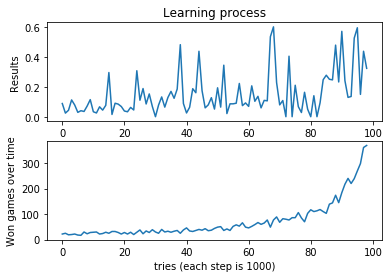

100%|██████████| 99999/99999 [01:06<00:00, 1505.96it/s]


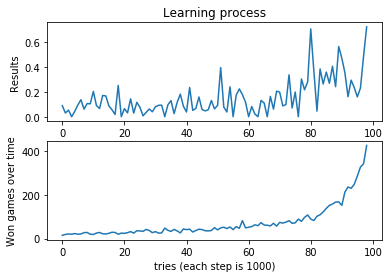

100%|██████████| 99999/99999 [01:02<00:00, 1608.59it/s]


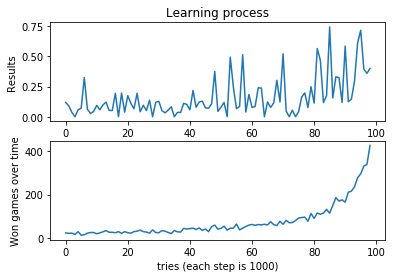

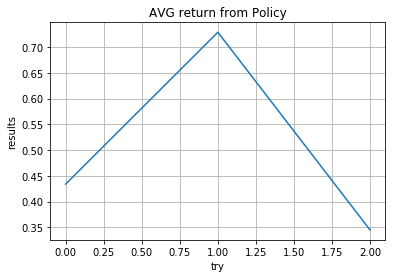

Mean 0.502666666667


In [21]:
x =[]
y = []
number_of_try = 1
number_of_runs = 1000000
q_tables = []
for i in range(number_of_try):
    # train
    #q_table, trace_of_learning, trace_of_won = monte_carlo_train(env, number_of_runs=number_of_runs)
    q_table, trace_of_learning, trace_of_won = sarsa_train(env, number_of_runs=number_of_runs)
    
    sleep(0.1)
    # evaluate
    result = evaluate_policy(env, q_table, 1000)
    
    # data for charts
    x.append(i)
    y.append(result)
    q_tables.append(q_table)
    
    # show learning
    plt.subplot(2, 1, 1)
    plt.plot(trace_of_learning)
    plt.title('Learning process')
    plt.ylabel('Results')

    plt.subplot(2, 1, 2)
    plt.plot(trace_of_won)
    plt.xlabel('tries (each step is 1000)')
    plt.ylabel('Won games over time')

    plt.show()

# total analitics    
fig, ax = plt.subplots()
ax.plot(x, y)

ax.set(xlabel='try', ylabel='results', title='AVG return from Policy')
ax.grid()

fig.savefig(str(number_of_runs) + '_' + str(number_of_try) + '_plot.png')
plt.show()

print('Mean', np.mean(y))


In [17]:
def get_clean_q_table(q_table):
    clean = np.zeros(q_table.shape)
    for state in range(q_table.shape[0]):
        max_action = np.argmax(q_table[state,:])
        clean[state][max_action] = 1
    return clean

clean_q_table = [] 
total_sum = np.zeros((16,4))
for q_table in q_tables:
    clean_table = get_clean_q_table(q_table)
    clean_q_table.append(clean_table)
    total_sum = np.add(total_sum, clean_table)
    
    
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# for n in range(number_of_try):
#     xs = np.arange(16*4)
#     ys = clean_q_table[n].flatten()
#     ax.bar(xs, ys, zs=n, zdir='y')
# ax.set_xlabel('state-action')
# ax.set_ylabel('tries')
# ax.set_zlabel('value: 0 or 1')
# plt.show()

print(total_sum/number_of_try)


[[ 0.33333333  0.66666667  0.          0.        ]
 [ 0.          0.          0.          1.        ]
 [ 0.33333333  0.          0.66666667  0.        ]
 [ 0.          0.          0.          1.        ]
 [ 1.          0.          0.          0.        ]
 [ 1.          0.          0.          0.        ]
 [ 0.66666667  0.          0.33333333  0.        ]
 [ 1.          0.          0.          0.        ]
 [ 0.          0.          0.          1.        ]
 [ 0.          0.66666667  0.33333333  0.        ]
 [ 1.          0.          0.          0.        ]
 [ 1.          0.          0.          0.        ]
 [ 1.          0.          0.          0.        ]
 [ 0.          0.          1.          0.        ]
 [ 0.          0.66666667  0.33333333  0.        ]
 [ 1.          0.          0.          0.        ]]
